In [1]:
import pandas as pd
from scipy.stats import poisson
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn
import numpy as np

In [2]:
df = pd.read_csv("Matches.csv")

C:\Users\atake\AppData\Local\Temp\ipykernel_7644\2097494830.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Matches.csv")


In [3]:
df.columns

Index(['Division', 'MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', 'HomeElo',
       'AwayElo', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'FTHome',
       'FTAway', 'FTResult', 'HTHome', 'HTAway', 'HTResult', 'HomeShots',
       'AwayShots', 'HomeTarget', 'AwayTarget', 'HomeFouls', 'AwayFouls',
       'HomeCorners', 'AwayCorners', 'HomeYellow', 'AwayYellow', 'HomeRed',
       'AwayRed', 'OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw',
       'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 'HandiSize',
       'HandiHome', 'HandiAway', 'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB',
       'C_PHB'],
      dtype='object')

In [4]:
df.head()

<bound method NDFrame.head of        Division   MatchDate MatchTime   HomeTeam    AwayTeam  HomeElo  \
0            F1  2000-07-28       NaN  Marseille      Troyes  1686.34   
1            F1  2000-07-28       NaN   Paris SG  Strasbourg  1714.89   
2            F2  2000-07-28       NaN  Wasquehal       Nancy  1465.08   
3            F1  2000-07-29       NaN    Auxerre       Sedan  1635.58   
4            F1  2000-07-29       NaN   Bordeaux        Metz  1734.34   
...         ...         ...       ...        ...         ...      ...   
230552      SP2  2025-06-01  17:30:00  Cartagena    Mirandes  1339.21   
230553      SP2  2025-06-01  17:30:00    Almeria    Tenerife  1544.16   
230554      SP2  2025-06-01  17:30:00  La Coruna       Elche  1473.67   
230555      SP2  2025-06-01  17:30:00     Oviedo       Cadiz  1574.90   
230556      SP2  2025-06-01  20:00:00    Cordoba    Albacete  1468.40   

        AwayElo  Form3Home  Form5Home  Form3Away  ...  MaxUnder25  HandiSize  \
0       1586.

In [5]:
df["Division"].unique()

array(['F1', 'F2', 'T1', 'D1', 'D2', 'B1', 'E2', 'E1', 'N1', 'P1', 'E0',
       'I2', 'SP2', 'SP1', 'I1', 'E3', 'SC0', 'SC1', 'SC2', 'SC3', 'G1',
       'EC', 'USA', 'SWE', 'NOR', 'IRL', 'BRA', 'ARG', 'MEX', 'JAP',
       'RUS', 'POL', 'DEN', 'ROM', 'AUT', 'SUI', 'FIN', 'CHN'],
      dtype=object)

In [40]:
# Pick only big five leagues of the Europe

division_filtered_df = df[df['Division'].isin(["F1", "SP1", "E0", "I1", "D1"])]
division_filtered_df = division_filtered_df[division_filtered_df['MatchDate'] > '2006']

In [41]:
selected_df = division_filtered_df[['Division', 'MatchDate', 'HomeTeam', 'AwayTeam', 'FTHome', 'FTAway', 'Over25', 'Under25']]

In [44]:
print(selected_df.isna().any().any())

selected_df = selected_df.dropna()

selected_df.isna().any().any()

True


np.False_

In [45]:
selected_df.head()

,Division,MatchDate,HomeTeam,AwayTeam,FTHome,FTAway,Over25,Under25
31152,E0,2006-01-02,Birmingham,Wigan,2.0,0.0,2.05,1.69
31153,E0,2006-01-02,Blackburn,Portsmouth,2.0,1.0,2.00,1.74
31154,E0,2006-01-02,Bolton,Liverpool,2.0,2.0,2.16,1.63
31155,E0,2006-01-02,Everton,Charlton,3.0,1.0,2.10,1.66
31156,E0,2006-01-02,Fulham,Sunderland,2.0,1.0,1.94,1.79


In [46]:
len(selected_df)

35008

In [67]:
def solve_lambda(under_prob, line=2):
    # Define the equation: CDF for 2 (default line is 2) goals = under probability
    func = lambda lam: poisson.cdf(line, lam) - under_prob
    # Initial guess for lambda
    lam_initial = line + 0.5
    # Solve
    lam_solution = fsolve(func, lam_initial)[0]
    return lam_solution

In [69]:
def estimate_goal(odds_under, odds_over, line=2, normalize=True):
    # Convert odds to probabilities
    prob_under = 1 / odds_under
    prob_over = 1 / odds_over

    if normalize:
        # Normalize the probabilities, removing the bookmarker margins
        total_prob = (prob_under + prob_over)
        normal_prob_under = prob_under / total_prob
        normal_prob_over = prob_over / total_prob

        estimated_goals = solve_lambda(normal_prob_under, line)
    else:
        # Estimate directly, without removing the margin. 
        estimated_goals = solve_lambda(prob_under, line)

    return estimated_goals

In [72]:
print(estimate_goal(1.87, 1.54))
print(estimate_goal(1.28, 2.49, 3))

print(estimate_goal(2.53, 1.28))
print(estimate_goal(1.54, 1.87, 3))

print(estimate_goal(2.47, 1.23))
print(estimate_goal(1.55, 1.76, 3))

print(estimate_goal(1.91, 1.52))
print(estimate_goal(1.29, 2.44, 3))

2.875673279205293
2.9408674491716984
3.4196854464649813
3.445731539915013
3.4381827551450996
3.5227944778623193
2.912187495941604
2.9690951588338166


In [50]:
selected_df['EstimatedGoals'] = [
    estimate_goal(u, o) for u, o in zip(selected_df['Under25'], selected_df['Over25'])
]

selected_df['UnfairEstimatedGoals'] = []

C:\Users\atake\AppData\Local\Temp\ipykernel_2556\571135674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['ExpectedGoals'] = [


In [51]:
selected_df["TotalGoals"] = selected_df['FTHome'] + selected_df['FTAway']

C:\Users\atake\AppData\Local\Temp\ipykernel_2556\2474576694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df["TotalGoals"] = selected_df['FTHome'] + selected_df['FTAway']


In [52]:
selected_df.head()

,Division,MatchDate,HomeTeam,AwayTeam,FTHome,FTAway,Over25,Under25,ExpectedGoals,TotalGoals
31152,E0,2006-01-02,Birmingham,Wigan,2.0,0.0,2.05,1.69,2.483206,2.0
31153,E0,2006-01-02,Blackburn,Portsmouth,2.0,1.0,2.00,1.74,2.535423,3.0
31154,E0,2006-01-02,Bolton,Liverpool,2.0,2.0,2.16,1.63,2.399188,4.0
31155,E0,2006-01-02,Everton,Charlton,3.0,1.0,2.10,1.66,2.443019,4.0
31156,E0,2006-01-02,Fulham,Sunderland,2.0,1.0,1.94,1.79,2.593322,3.0


In [59]:
print(f'The average of actual goals scored per game: {selected_df["TotalGoals"].mean()}')
print(f'The average of estimated goals per game by bet365: {selected_df["EstimatedGoals"].mean()}')

The average of actual goals scored per game: 2.7162362888482634
The average of estimated goals per game by bet365: 2.7218493209835386


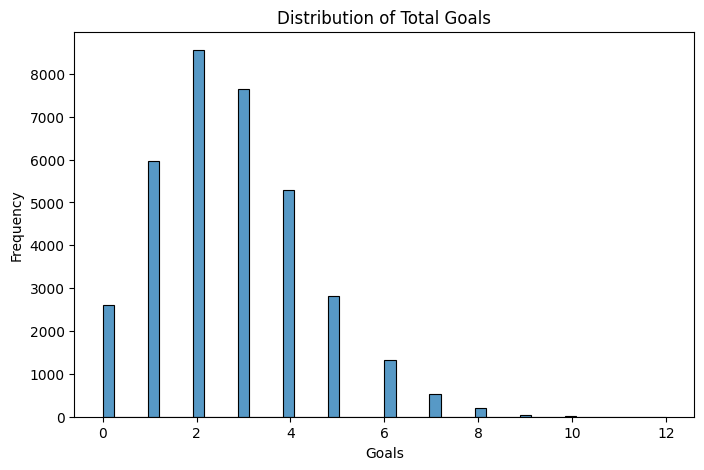

In [53]:
plt.figure(figsize=(8, 5))
sns.histplot(selected_df["TotalGoals"], bins=50)

plt.title('Distribution of Total Goals')
plt.xlabel('Goals')
plt.ylabel('Frequency')

plt.show()



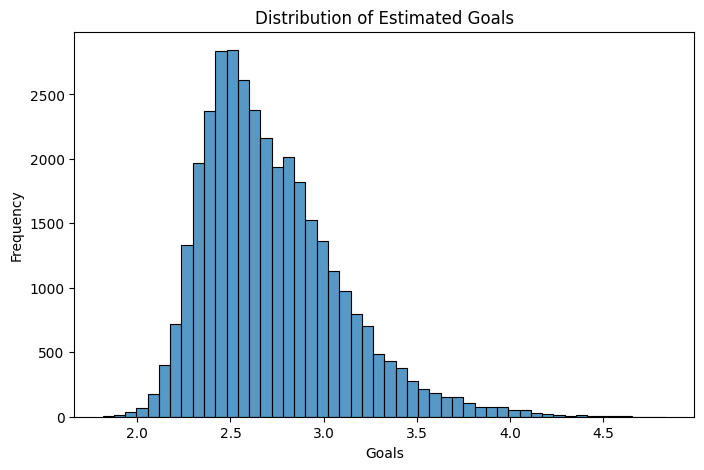

In [60]:
plt.figure(figsize=(8, 5))
sns.histplot(selected_df["EstimatedGoals"], bins=50)

plt.title('Distribution of Estimated Goals')
plt.xlabel('Goals')
plt.ylabel('Frequency')

plt.show()


C:\Users\atake\AppData\Local\Temp\ipykernel_14640\2399967692.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Goals', y='Type', data=plot_df, scale='width', inner='quartile', palette=['skyblue', 'salmon'])
C:\Users\atake\AppData\Local\Temp\ipykernel_14640\2399967692.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Goals', y='Type', data=plot_df, scale='width', inner='quartile', palette=['skyblue', 'salmon'])


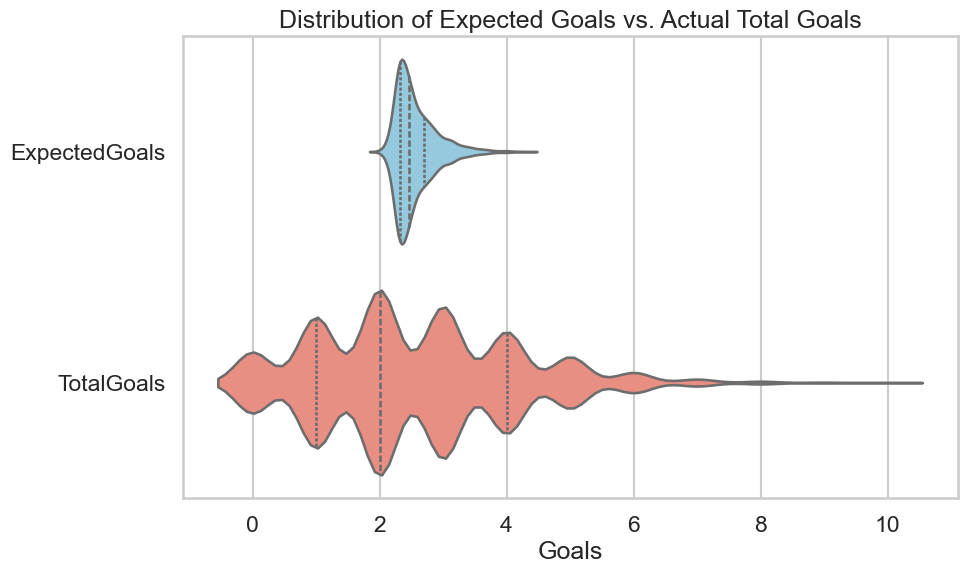

In [47]:
# Melt the dataframe for seaborn
plot_df = pd.melt(selected_df, value_vars=['EstimatedGoals', 'TotalGoals'], 
                   var_name='Type', value_name='Goals')

plt.figure(figsize=(10, 6))
sns.violinplot(x='Goals', y='Type', data=plot_df, scale='width', inner='quartile', palette=['skyblue', 'salmon'])

plt.title('Distribution of Estimated Goals vs. Actual Total Goals')
plt.xlabel('Goals')
plt.ylabel('')
plt.show()


In [54]:
var_expected = over_under_df["EstimatedGoals"].var()
var_actual = over_under_df["TotalGoals"].var()

print(f"Variance of Estimated Goals: {var_expected:.3f}")
print(f"Variance of Actual Total Goals: {var_actual:.3f}")


Variance of Expected Goals: 0.110
Variance of Actual Total Goals: 2.555


C:\Users\atake\AppData\Local\Temp\ipykernel_2556\3633960695.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['OddsBin'] = pd.cut(selected_df['Over25'], bins=bins, labels=labels, include_lowest=True)
C:\Users\atake\AppData\Local\Temp\ipykernel_2556\3633960695.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = selected_df.groupby('OddsBin').agg({


     OddsBin  ExpectedGoals  TotalGoals
0   1.15-1.2       4.265242    4.392405
1   1.2-1.25       4.017567    4.257282
2   1.25-1.3       3.821914    3.996047
3   1.3-1.35       3.669357    3.698163
4   1.35-1.4       3.519846    3.422535
5   1.4-1.45       3.385137    3.512755
6   1.45-1.5       3.275615    3.297240
7   1.5-1.55       3.179145    3.212170
8   1.55-1.6       3.088970    3.144460
9   1.6-1.65       3.010684    3.006184
10  1.65-1.7       2.936247    2.936957
11  1.7-1.75       2.868688    2.827223
12  1.75-1.8       2.804337    2.790859
13  1.8-1.85       2.744292    2.756966
14  1.85-1.9       2.686567    2.709581
15  1.9-1.95       2.631545    2.640881
16  1.95-2.0       2.580155    2.568543
17  2.0-2.05       2.531417    2.531701
18  2.05-2.1       2.485689    2.500493
19  2.1-2.15       2.443742    2.343685
20  2.15-2.2       2.404152    2.368454
21  2.2-2.25       2.366581    2.350113
22  2.25-2.3       2.331526    2.279304
23  2.3-2.35       2.299234    2.270588


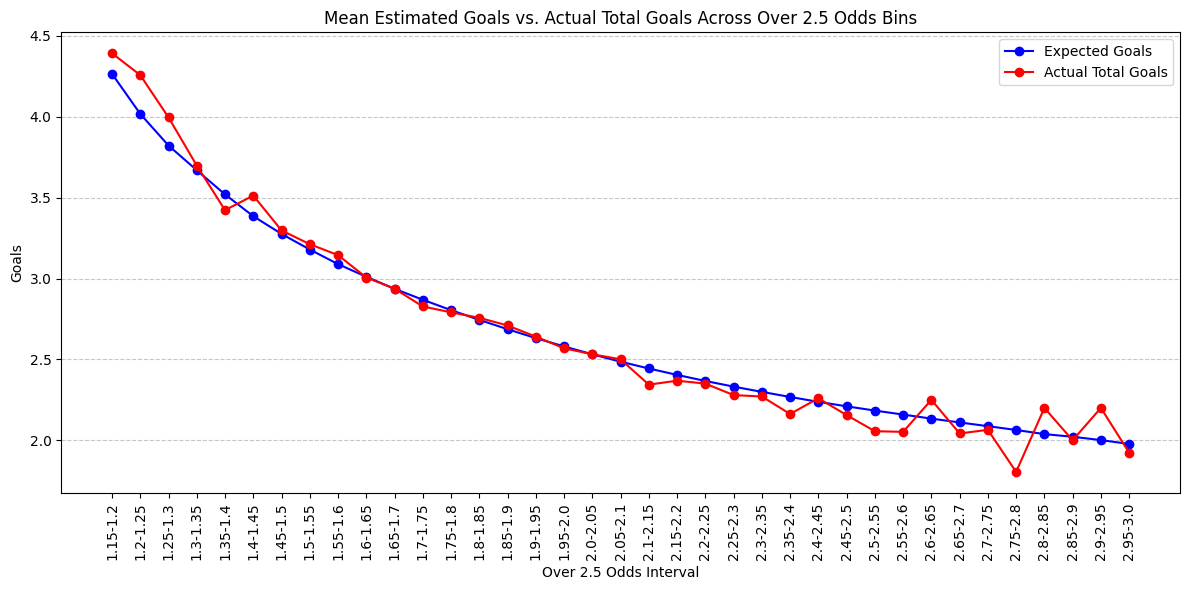

In [64]:
# Define bin edges
bins = np.arange(1.15, 3.05, 0.05)  # e.g., 1.15-1.20, ..., 3.00-3.05

# Create labels for bins
labels = [f"{round(b,2)}-{round(b+0.05,2)}" for b in bins[:-1]]

# Bin the Over2.5 odds
selected_df['OddsBin'] = pd.cut(selected_df['Over25'], bins=bins, labels=labels, include_lowest=True)

# Group by bins and calculate means
grouped = selected_df.groupby('OddsBin').agg({
    'ExpectedGoals': 'mean',
    'TotalGoals': 'mean'
}).reset_index()

print(grouped)


plt.figure(figsize=(12,6))

plt.plot(grouped['OddsBin'], grouped['ExpectedGoals'], marker='o', label='Expected Goals', color='blue')
plt.plot(grouped['OddsBin'], grouped['TotalGoals'], marker='o', label='Actual Total Goals', color='red')

plt.title('Mean Estimated Goals vs. Actual Total Goals Across Over 2.5 Odds Bins')
plt.xlabel('Over 2.5 Odds Interval')
plt.ylabel('Goals')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()


C:\Users\atake\AppData\Local\Temp\ipykernel_2556\498199077.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['OddsBin'] = pd.cut(selected_df['Over25'], bins=bins, labels=labels, include_lowest=True)
C:\Users\atake\AppData\Local\Temp\ipykernel_2556\498199077.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = selected_df.groupby('OddsBin').agg({
C:\Users\atake\AppData\Local\Temp\ipykernel_2556\498199077.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

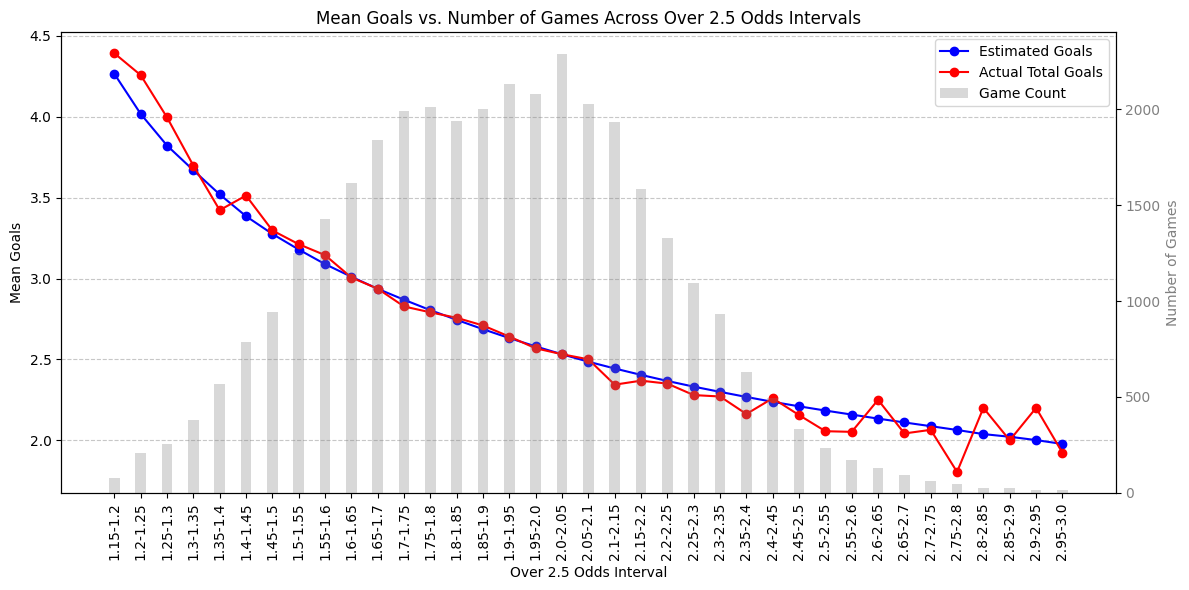

In [66]:
# --- Bin the odds ---
bins = np.arange(1.15, 3.05, 0.05)  # From 1.15 to 3.00
labels = [f"{round(b,2)}-{round(b+0.05,2)}" for b in bins[:-1]]

selected_df['OddsBin'] = pd.cut(selected_df['Over25'], bins=bins, labels=labels, include_lowest=True)

# --- Group the data ---
grouped = selected_df.groupby('OddsBin').agg({
    'ExpectedGoals': 'mean',
    'TotalGoals': 'mean',
    'Over25': 'count'  # Game count
}).rename(columns={'Over25': 'GameCount'}).reset_index()

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot mean goals on left Y-axis
ax1.plot(grouped['OddsBin'], grouped['ExpectedGoals'], color='blue', marker='o', label='Estimated Goals')
ax1.plot(grouped['OddsBin'], grouped['TotalGoals'], color='red', marker='o', label='Actual Total Goals')

ax1.set_xlabel('Over 2.5 Odds Interval')
ax1.set_ylabel('Mean Goals', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticklabels(grouped['OddsBin'], rotation=90)

# Add grid
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Legend for goal lines
ax1.legend(loc='upper left')

# Create second Y-axis for game count
ax2 = ax1.twinx()
ax2.bar(grouped['OddsBin'], grouped['GameCount'], width=0.4, color='gray', alpha=0.3, label='Game Count')
ax2.set_ylabel('Number of Games', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Legend for game count
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Mean Goals vs. Number of Games Across Over 2.5 Odds Intervals')

plt.tight_layout()
plt.show()
